# IdentifyingCrops
Name: Jaimie Chin  
Date: 3rd March 2023  
Class: DS.UA.301 - Machine Learning for Climate Change  

## Background
Here you will use remote sensing data collected from the Sentinel-2 satellite to find crops. Algorithms that can identify crops are helpful in assessing land use changes associated with agriculture. 

Sentinel-2 collects data in 13 spectral bands (regions of the electromagnetic spectrum), as shown here:
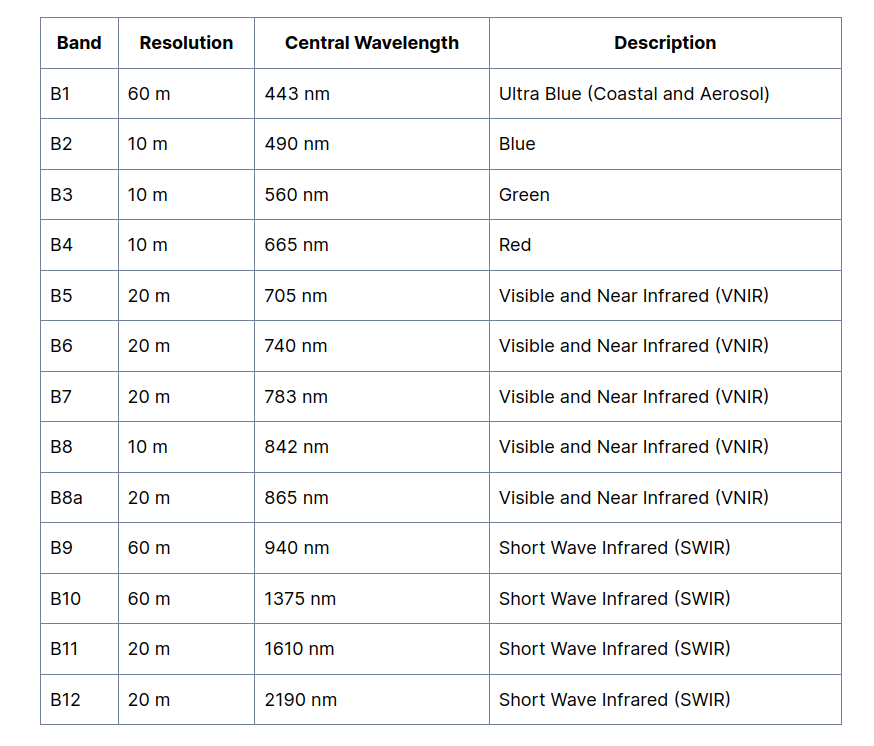

To identify crops, some bands are more helpful than others. For example, B2-B4 are the visible spectrum and reflect what we see, near-infrared wavelengths can be sensitive to chlorophyll and short wave infrared (SWIR) wavelengths are sensitive to water content. Bands such as B1 and B10, however, respond more to clouds and particles in the air and are therefore less useful here. 

Scientists also create indices for certain purposes. These indices are combinations of values from different bands. For our purposes, the normalized difference vegetation index (NDVI) will be helpful as it is specifically suited to identifying plants. It is calculated as:

$$ NDVI = (B8 - B4) / (B8 + B4) $$

We will use data collected from the Togolese Republic (as described in [this paper](https://arxiv.org/pdf/2006.16866.pdf), with data accessed through [this repo](https://github.com/nasaharvest/cropharvest)). 

The data contains 1290 data points in the training set and 306 in the test set. Each data point represents one spatial location, and contains all Sentintel-2 bands except B1 and B10 plus the pre-calculated NDVI. Therefore, each data point has 12 features in total. Each point is labeled as containing crops (1) or not (0).   

Download the npz [here](https://drive.google.com/file/d/14jJCC0srUmoAIWWOESE-s4mWbMq3OrH9/view?usp=sharing) and unpack it as below. 

### Import Libraries & Data 

In [1]:
# Import packages and libraries 
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

In [2]:
# Load the data 
data_path = 'togo_crops_data.npz'
data = np.load(data_path)
X_train = data['arr_0']; y_train = data['arr_1']; X_test = data['arr_2']; y_test = data['arr_3']

In [3]:
# Create dataframes from data for plotting 
cols = ['Feature_1', 'Feature_2', 'Feature_3', 'Feature_4',
           'Feature_5', 'Feature_6', 'Feature_7', 'Feature_8',
           'Feature_9', 'Feature_10', 'Feature_11', 'Feature_12', 'Location']

# Train dataframe 
X_train_df = pd.DataFrame(X_train)
y_train_df = pd.DataFrame(y_train)
train_df = pd.concat([X_train_df, y_train_df], axis=1, ignore_index=True)
train_df.columns = cols

# Test dataframe -- for later 
X_test_df = pd.DataFrame(X_test)
y_test_df = pd.DataFrame(y_test)
test_df = pd.concat([X_test_df, y_test_df], axis=1, ignore_index=True)
test_df.columns = cols

## Plot Feature Frequency 
Plot histograms of the training values of each feature. Specifically, for each feature, make a single plot that contains two histograms: one of the values for locations with crops and one for those without *(1 pt)*. Set the bins the same for each *(.5 pt)* and reduce the transparency of each so that both are visible *(.5 pt)*. E.g., they should look something like this: 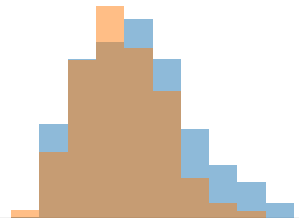

Based on these plots, do you think the first feature would be useful for identifying crops? What about the 8th? *(.5 pt each)*


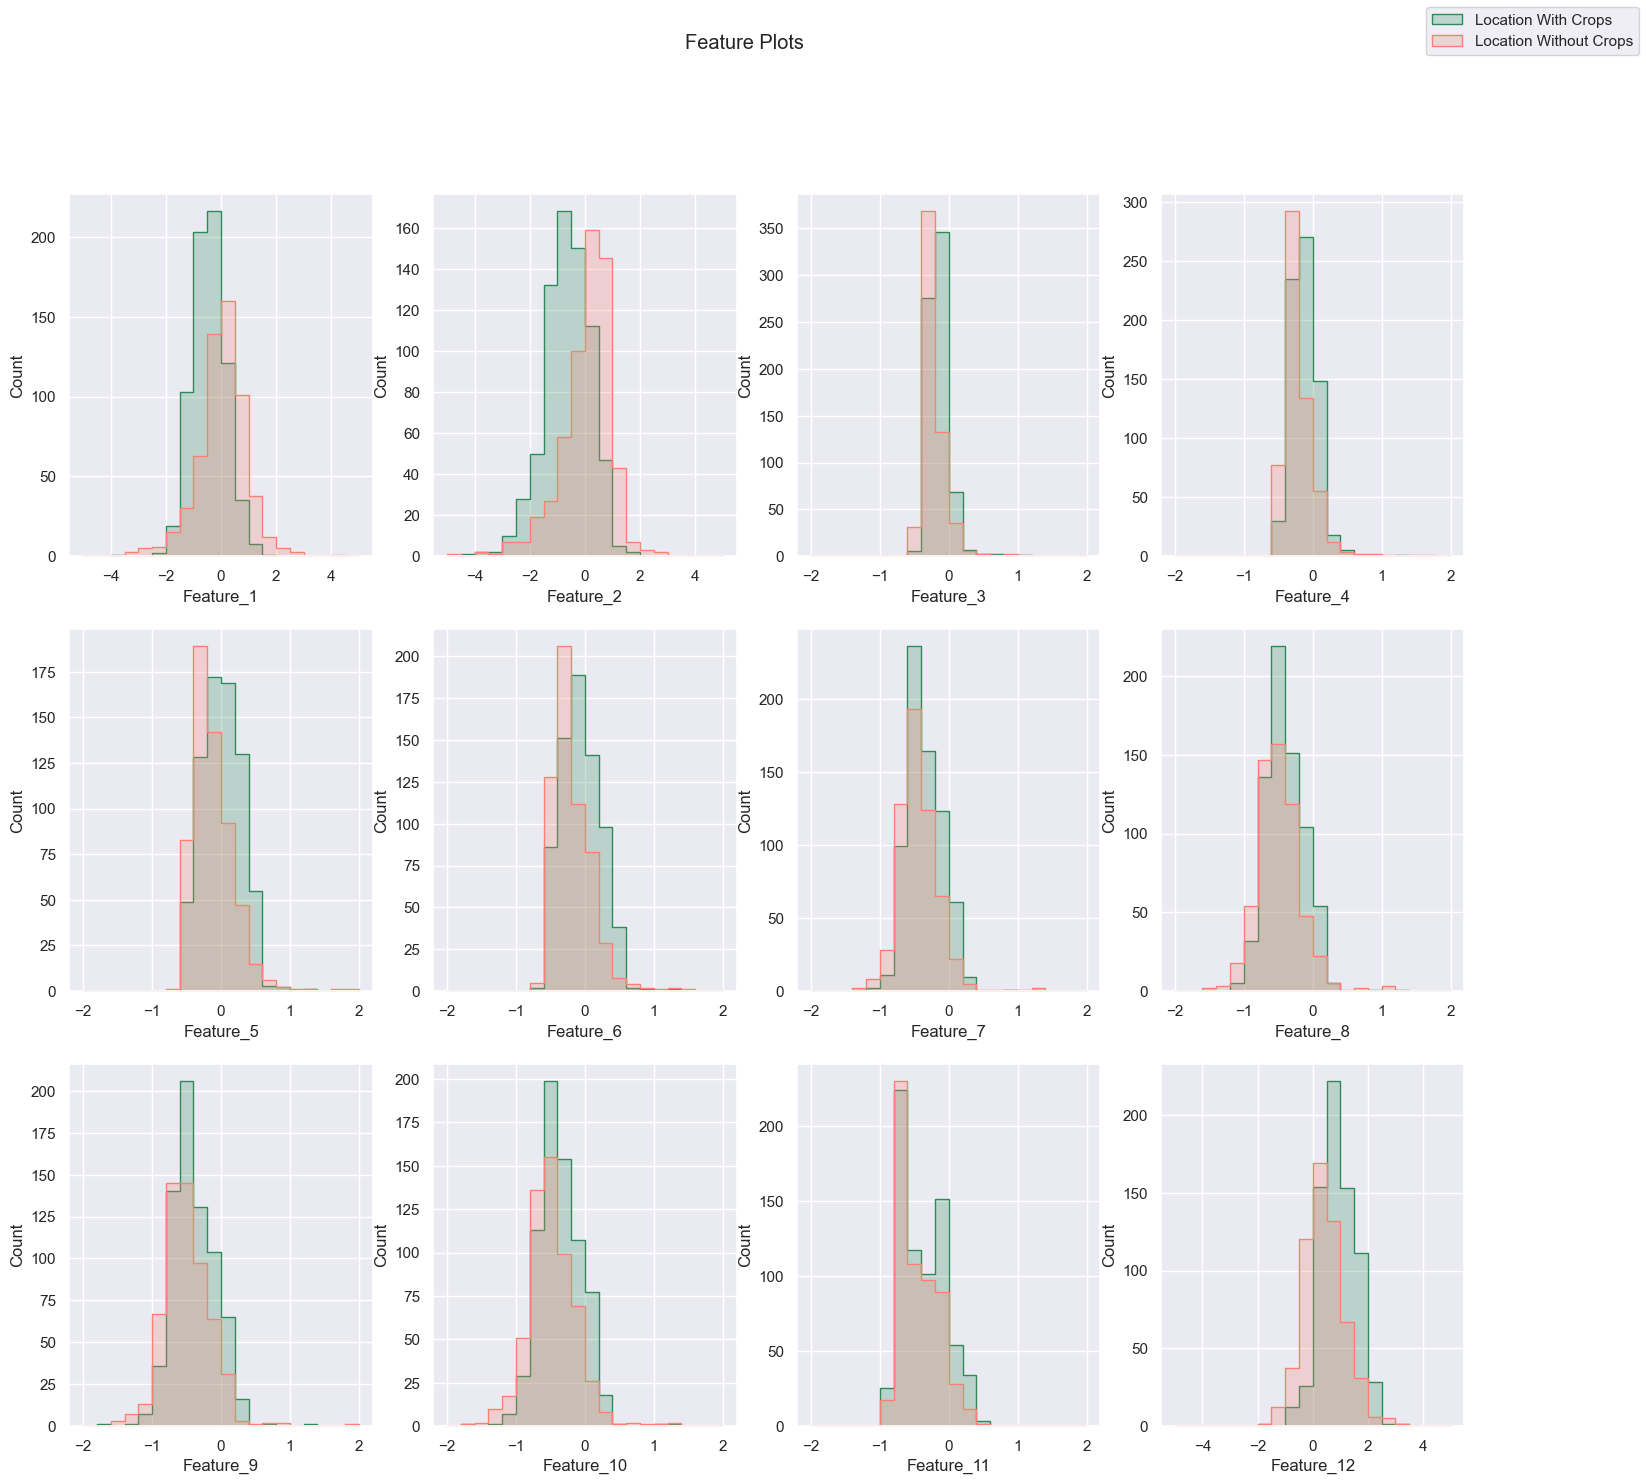

In [4]:
# Create histogram plot 

# Set seaborn figure and palette 
sns.set(style="darkgrid")
palette = ["salmon", "seagreen"]
fig, axs = plt.subplots(3, 4, figsize=(18, 16))
fig.suptitle('Feature Plots')

# Plot each feature
sns.histplot(data=train_df, x="Feature_1", hue="Location", element='step',
             bins=20, binrange=(-5, 5), legend=False, palette=palette, ax=axs[0, 0])

sns.histplot(data=train_df, x="Feature_2", hue="Location", element='step',
             bins=20, binrange=(-5, 5), legend=False, palette=palette, ax=axs[0, 1])

sns.histplot(data=train_df, x="Feature_3", hue="Location", element='step',
             bins=20, binrange=(-2, 2), legend=False, palette=palette, ax=axs[0, 2])

sns.histplot(data=train_df, x="Feature_4", hue="Location", element='step',
             bins=20, binrange=(-2, 2), legend=False, palette=palette, ax=axs[0, 3])

sns.histplot(data=train_df, x="Feature_5", hue="Location", element='step',
             bins=20, binrange=(-2, 2), legend=False, palette=palette, ax=axs[1, 0])

sns.histplot(data=train_df, x="Feature_6", hue="Location", element='step',
             bins=20, binrange=(-2, 2), legend=False, palette=palette, ax=axs[1, 1])

sns.histplot(data=train_df, x="Feature_7", hue="Location", element='step',
             bins=20, binrange=(-2, 2), legend=False, palette=palette, ax=axs[1, 2])

sns.histplot(data=train_df, x="Feature_8", hue="Location", element='step',
             bins=20, binrange=(-2, 2), legend=False, palette=palette, ax=axs[1, 3])

sns.histplot(data=train_df, x="Feature_9", hue="Location", element='step',
             bins=20, binrange=(-2, 2), legend=False, palette=palette, ax=axs[2, 0])

sns.histplot(data=train_df, x="Feature_10", hue="Location", element='step',
             bins=20, binrange=(-2, 2), legend=False, palette=palette, ax=axs[2, 1])

sns.histplot(data=train_df, x="Feature_11", hue="Location", element='step',
             bins=20, binrange=(-2, 2), legend=False, palette=palette, ax=axs[2, 2])

sns.histplot(data=train_df, x="Feature_12", hue="Location", element='step',
             bins=20, binrange=(-5, 5), legend=False, palette=palette, ax=axs[2, 3])

# Add legend 
plt.figlegend(["Location With Crops", "Location Without Crops"])

# Show plots
plt.show()

### Based on these plots, do you think the first feature would be useful for identifying crops? What about the 8th? *(.5 pt each)*
Yes, I think that the first feature would be useful for identifying crops because there is less of an overlap between the two histograms of locations with crops and locations without crops. For example, looking at the histogram for Feature 1, it is more likely for a location to have crops when the value of Feature 1 is below 0.

No, I do not think Feature 8 would be useful for identifying crops because there is a greater overlap between the two histograms of locations with crops and locations without crops. From the histogram, it seems that values of Feature 8 all have a likely chance of having locations with crops and without crops. 

## Logistic Regression Model for All Features
Train a logistic regression model on the training data to classify each data point as containing crops or not *(1 pt)*. Evaluate the model separately on both the training and test set according to the overall classification accuracy. Because this a binary classification model, we can also use more fine-grained measures of performance such as [precision and recall](https://en.wikipedia.org/wiki/Precision_and_recall). Evaluate the model on these metrics as well *(.5 pt for each metric for training and test - 3 pts total)*. 

In [5]:
# Preprocessing Data 
sc_x = StandardScaler()
X_train = sc_x.fit_transform(X_train)
X_test = sc_x.transform(X_test)

In [6]:
# Instantiate Logistic Regression Model 
model = LogisticRegression()

# Fit the model to the train data
model.fit(X_train, y_train)

# Assess the train data 
y_train_pred = model.predict(X_train)
print('Accuracy of logistic regression classifier on train set: {:.3f}'.format(
    accuracy_score(y_train, y_train_pred)))
print('Precision Score of logistic regression classifier on train set: {:.3f}'.format(
    precision_score(y_train, y_train_pred)))
print('Recall Score of logistic regression classifier on train set: {:.3f}'.format(
    recall_score(y_train, y_train_pred)))

# Assess the test data
y_test_pred = model.predict(X_test)
print('\nAccuracy of logistic regression classifier on test set: {:.3f}'.format(
    accuracy_score(y_test, y_test_pred)))
print('Precision Score of logistic regression classifier on test set: {:.3f}'.format(
    precision_score(y_test, y_test_pred)))
print('Recall Score of logistic regression classifier on test set: {:.3f}'.format(
    recall_score(y_test, y_test_pred)))

Accuracy of logistic regression classifier on train set: 0.748
Precision Score of logistic regression classifier on train set: 0.754
Recall Score of logistic regression classifier on train set: 0.804

Accuracy of logistic regression classifier on test set: 0.703
Precision Score of logistic regression classifier on test set: 0.547
Recall Score of logistic regression classifier on test set: 0.821


### Looking at the results on the test data, which is your model better at: catching true crops that exist or not labeling non-crops as crops? *(1 pt)*

Looking at the results on the test data, our model is better at **catching true crops**. This is because the Recall score, which represents the number of positive predictions made out of all positive examples in the dataset, is a higher value than the Precision Score, which represents the number of positive class predictions that actually belong to the positive class.  

In other words, the Recall Score indicates the ratio of labeling true crops as crops to labeling true crops as crops and true crops as non-crops. The Precision score indicates the ratio of labeling true crops as crops to labeling true crops and non-crops as crops. 

Since our Recall Score is higher, this tells us that the number of true crops as crops labels is nearly identical to the number of true crops as crops and true crops as non-crops labels. Meaning, the number of true crops as non-crops labels (False Negatives) are rather few, so our model is better at catching true crops that exist. 

Since our Precision Score is lower, this tells us that the number of true crops as crops labels is almost half of the number of true crops and non-crops as crops labels. Meaning, the number of non-crops as crops labels (False Positives) is almost identical to the number of true crops as crops (True Positives), so our model is worse as not labeling non-crops as crops. 

## Feature Selection Logistic Regression
Create two new data sets from this data: one that only contains the 2nd through 11th features and one that contains the remaining three features *(.5 pt for each)*. Train two new logistic regression models with these two new datasets and report their test accuracy *(.5 pt for each)*. In this case, does the model with more features perform better? Why or why not? *(1pt)*

In [194]:
# Create new dataframes 

# Features 2 - 11
feat1_X_train_df = train_df[['Feature_2', 'Feature_3', 'Feature_4',
                   'Feature_5', 'Feature_6', 'Feature_7', 'Feature_8',
                   'Feature_9', 'Feature_10', 'Feature_11']].copy()
feat1_X_test_df = test_df[['Feature_2', 'Feature_3', 'Feature_4',
                           'Feature_5', 'Feature_6', 'Feature_7', 'Feature_8',
                           'Feature_9', 'Feature_10', 'Feature_11']].copy()

# Features 1 & 12
feat2_X_train_df = train_df[['Feature_1', 'Feature_12']].copy()
feat2_X_test_df = test_df[['Feature_1', 'Feature_12']].copy()

In [195]:
# Preprocessing Data
feat1_X_train_df = sc_x.fit_transform(feat1_X_train_df)
feat1_X_test_df = sc_x.transform(feat1_X_test_df)
feat2_X_train_df = sc_x.fit_transform(feat2_X_train_df)
feat2_X_test_df = sc_x.transform(feat2_X_test_df)

In [196]:
# Instantiate Logistic Regression Model for Features 2 - 11
feat1_model = LogisticRegression()

# Fit the model to the train data
feat1_model.fit(feat1_X_train_df, y_train)

# Assess the test data
y_test_pred = feat1_model.predict(feat1_X_test_df)
print('\nAccuracy of logistic regression classifier on test set with Features 2 - 11: {:.3f}'.format(
    accuracy_score(y_test, y_test_pred)))
print('Precision Score of logistic regression classifier on test set with Features 2 - 11: {:.3f}'.format(
    precision_score(y_test, y_test_pred)))
print('Recall Score of logistic regression classifier on test set with Features 2 - 11: {:.3f}'.format(
    recall_score(y_test, y_test_pred)))


Accuracy of logistic regression classifier on test set with Features 2 - 11: 0.686
Precision Score of logistic regression classifier on test set with Features 2 - 11: 0.530
Recall Score of logistic regression classifier on test set with Features 2 - 11: 0.830


In [197]:
# Instantiate Logistic Regression Model for Features 1 & 12
feat2_model = LogisticRegression()

# Fit the model to the train data
feat2_model.fit(feat2_X_train_df, y_train)

# Assess the test data
y_test_pred = feat2_model.predict(feat2_X_test_df)
print('\nAccuracy of logistic regression classifier on test set with Features 1 & 12: {:.3f}'.format(
    accuracy_score(y_test, y_test_pred)))
print('Precision Score of logistic regression classifier on test set with Features 1 & 12: {:.3f}'.format(
    precision_score(y_test, y_test_pred)))
print('Recall Score of logistic regression classifier on test set with Features 1 & 12: {:.3f}'.format(
    recall_score(y_test, y_test_pred)))


Accuracy of logistic regression classifier on test set with Features 1 & 12: 0.788
Precision Score of logistic regression classifier on test set with Features 1 & 12: 0.650
Recall Score of logistic regression classifier on test set with Features 1 & 12: 0.840


In [198]:
# Create a table of accuracy, precision & recall scores for analysis 
score_table = pd.DataFrame({
    'Accuracy Score': [0.748, 0.703, 0.686, 0.788],
    'Precision Score': [0.754, 0.547, 0.530, 0.650],
    'Recall Score': [0.804, 0.821, 0.830, 0.840]
}, index=['All Features Train Set',
          'All Features Test Set',
          'Features 2 - 11 Test Set',
          'Features 1 & 12 Test Set'])

# Show table 
score_table

,Accuracy Score,Precision Score,Recall Score
All Features Train Set,0.748,0.754,0.804
All Features Test Set,0.703,0.547,0.821
Features 2 - 11 Test Set,0.686,0.530,0.830
Features 1 & 12 Test Set,0.788,0.650,0.840


### In this case, does the model with more features perform better? Why or why not? *(1pt)*

The model with more features performs **worse** compared to the model that uses only feature 1 & 12 *and* the model that uses all the features in the test set. This is most likely the case as the model with features 2 - 11 is overfitting the training data with features that are less important in determining locations with and without crops in the test data. In fact, given the accuracy, precision, and recall score of the model with Features 1 & 12 compared to the model with all features, Features 1 & 12 seems to be the most important when determining the accuracy of locations with crops and without crops. It is most likely that the model with all features and Features 2 - 11 contain uneccesary/unhelpful features in order to determine crop location.